In [199]:
import pandas as pd
from pathlib import Path
import numpy as np
from category_encoders import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [201]:
translation = {
    "Kuntanro": "Municipality number",
    "KUNTA": "Municipality",
    "Oulun kaupungin Y-tunnus": "Oulu city Business ID",
    "Tosite numero": "Document number",
    "Toimittajan nimi": "Vendor name",
    "Toimittajan y-tunnus": "Vendor Business ID",
    "Toimittajan maakoodi": "Vendor country code",
    "Laskun summa ilman ALV:tä": "Invoice sum without VAT",
    "Tositepäivämäärä": "Document date",
    "TILI": "GL account number",
    "TILIN NIMI": "Account name",
    "Palveluluokka": "Service class",
    "Kokonaissumma": "Total amount",
    "ALV-KOODI": "VAT code",
    "RIVIN OSUUS VERO": "Line tax amount",
    "Kustannuspaikka": "Cost center",
}
TRAIN_SET_SIZE = 0.8
SEED_NUMBNER = 33

In [7]:
data_excel = pd.read_excel('data/ostolaskudata_2021_oulunkaupunki.xlsx',nrows=317369)

In [69]:
def col_info(df,n_sample=1):
    print(f"{'Name':<50}{'EN':<50}{'dtype':^10}{'Example':<60}{'N-unique':<4}")
    print('-'*(50+50+10+60+4))
    for col in df.columns:
        print(f"{col:<50}{translation.get(col,col):<50}{df[col].dtype.__str__():^10}{df[col].sample(n_sample).values.__str__():<60}{df[col].unique().shape[0]:<4}")
    

In [9]:
col_info(data_excel)

Name                                              EN                                                  dtype   Example                                                     N-unique
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Kuntanro                                          Municipality number                                 int64   [546]                                                       1   
KUNTA                                             Municipality                                        object  ['Peruskunta']                                              11  
Oulun kaupungin Y-tunnus                          Oulu city Business ID                               object  ['0187690-1']                                               1   
Tosite numero                                     Document number                                     object  ['32_97836'

In [10]:
drop_cols = [
    "Kuntanro",  # same id no information
    "Oulun kaupungin Y-tunnus", #same id no information
    "Tosite numero",  # pretty random no useful information
    "Palveluluokka",  # always None
    "TILIN NIMI" # Correlated with the target and it is cheating to be part of the training set
]


Bussiness id is misleading

In [11]:
keys = data_excel["'Toimittajan y-tunnus'"].unique()
mapper = data_excel.groupby('Toimittajan nimi').agg({'Toimittajan y-tunnus':lambda x : set(x),'ALV-KOODI':lambda x : set(x)})

In [12]:
for row,val in mapper.iterrows():
    f = len(val['Toimittajan y-tunnus'])
    if f>1:
        print(f"{row:<40}{f:^5}{val['ALV-KOODI'].__str__():<10}")
        

FICON OY                                  2  {124.0}   
IS-VET OY                                 2  {124.0}   
MADS DENTAL                               2  {124.0}   
MANNERHEIMIN LASTENSUOJELULIIT            5  {100.0}   
PIHLAJALINNA OULU OY                      2  {nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 224.0, nan, nan, 100.0, nan, 105.0, nan, nan, nan, nan, nan, nan, nan, nan, 124.0, nan, nan}
SUOMEN KALENTERIT OY                      2  {124.0}   
VALTIOKONTTORI / RAHOITUS                 2  {nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan}
Yksityinen elinkeinonharjoittaja         810 {400.0, nan, nan, nan, 814.0, nan, nan, nan, nan, nan, 324.0, nan, 200.0, nan, nan, nan, nan, 224.0, 100.0, nan, 105.0, nan, 110.0, nan, 114.0, 124.0}
Yksityinen elinkeinonharjoittaja         36  {400.0, 110.0, 124.0, 814.0}


In [84]:
drop_cols.append('Toimittajan y-tunnus')
data_cleansed = data_excel.drop(drop_cols,axis=1).dropna()
# data_cleansed['Tositepäivämäärä'] = data_cleansed['Tositepäivämäärä'].apply(lambda x: pd.to_datetime(x)).apply(lambda x: x.toordinal())
data_cleansed[["month","day"]] = data_cleansed['Tositepäivämäärä'].astype('str').str[2:].str.extract(pat=r'(?P<month>\d{2})(?P<day>\d{2})',expand=True).astype(int)
data_cleansed.drop("Tositepäivämäärä",axis=1,inplace=True)
# data_cleansed.drop("Tositepäivämäärä",inplace=True)
data_cleansed.rename(columns=translation,inplace=True)
data_cleansed["Vendor name"] = data_cleansed["Vendor name"].astype('str').str.strip()
col_info(data_cleansed,n_sample=2)

Name                                              EN                                                  dtype   Example                                                     N-unique
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Municipality                                      Municipality                                        object  ['Peruskunta' 'Peruskunta']                                 11  
Vendor name                                       Vendor name                                         object  ['LINDSTRÖM OY' 'MONETRA OULU OY']                          5420
Vendor country code                               Vendor country code                                 object  ['FI' 'FI']                                                 6   
Invoice sum without VAT                           Invoice sum without VAT                            float64  [102.02  23

In [200]:
target = ['VAT code','_GL account number_']
feature_columns = data_cleansed.columns.difference(target)
X = data_cleansed[feature_columns]
y = data_cleansed[target]
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=1-TRAIN_SET_SIZE,random_state=SEED_NUMBNER)

## Imbalanced data

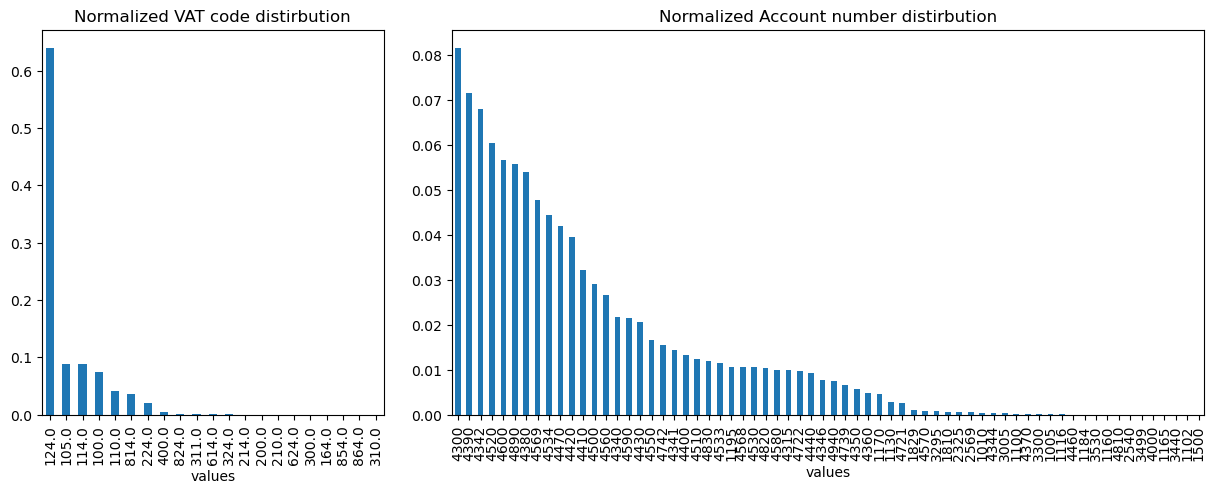

In [198]:
fig = plt.figure(figsize=(15,5))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0, :1])
ax2 = fig.add_subplot(gs[0, 1:])

ax = (train_y['VAT code'].value_counts()/train_y.shape[0]).plot.bar(title='Normalized VAT code distirbution',xlabel='values',ax=ax1)
ax = (train_y['_GL account number_'].value_counts()/train_y.shape[0]).plot.bar(title='Normalized Account number distirbution',xlabel='values',ax=ax2)
